In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [3]:
train = gen.flow_from_directory("BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")
                
val = gen.flow_from_directory("BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [4]:
classes

{'BrainTumor': 0, 'Healthy': 1}

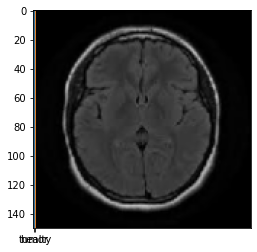

In [5]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

In [6]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten, Input
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers

In [7]:
input_tensor = Input(shape=(100, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

resnet_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable=False

resnet = Sequential()
resnet.add(resnet_model)
resnet.add(layers.Conv2D(32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
resnet.add(layers.ReLU())
resnet.add(layers.MaxPooling2D(pool_size=(2,2)))
resnet.add(layers.Flatten())
resnet.add(layers.Dense(activation='relu', units=64))
resnet.add(layers.Dropout(0.2))
resnet.add(layers.Dense(activation='sigmoid', units=1))

resnet.compile(loss=BinaryCrossentropy(), optimizer=SGD(0.001), metrics=["accuracy"])

resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11214976  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [8]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [9]:
history = resnet.fit(train,verbose=1,callbacks = [earlystopping],epochs=20,validation_data=(val))

Epoch 1/20
15/15 [==============================] - 73s 5s/step - loss: 0.6460 - accuracy: 0.6525 - val_loss: 0.6715 - val_accuracy: 0.7432
Epoch 2/20
15/15 [==============================] - 66s 4s/step - loss: 0.5148 - accuracy: 0.7522 - val_loss: 0.6626 - val_accuracy: 0.7008
Epoch 3/20
15/15 [==============================] - 60s 4s/step - loss: 0.4804 - accuracy: 0.7742 - val_loss: 0.6536 - val_accuracy: 0.6355
Epoch 4/20
15/15 [==============================] - 63s 4s/step - loss: 0.4406 - accuracy: 0.7998 - val_loss: 0.6502 - val_accuracy: 0.5724
Epoch 5/20
15/15 [==============================] - 58s 4s/step - loss: 0.4187 - accuracy: 0.8098 - val_loss: 0.6450 - val_accuracy: 0.5724
Epoch 6/20
15/15 [==============================] - 65s 4s/step - loss: 0.3865 - accuracy: 0.8289 - val_loss: 0.6447 - val_accuracy: 0.5713
Epoch 7/20
15/15 [==============================] - 58s 4s/step - loss: 0.3701 - accuracy: 0.8462 - val_loss: 0.6429 - val_accuracy: 0.5571
Epoch 8/20
15/15 [==

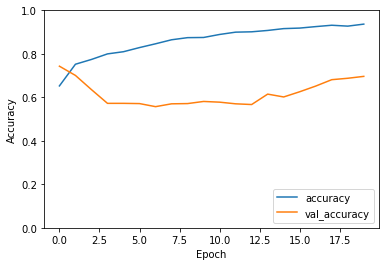

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


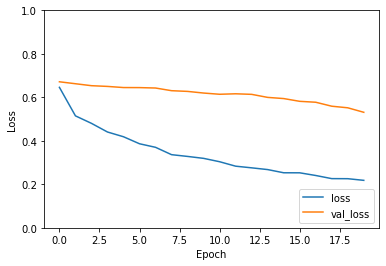

In [11]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
gen = ImageDataGenerator(rescale=1./255,zoom_range=(0.99,0.99),dtype=tf.float32)
test = gen.flow_from_directory("Test/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

classes = val.class_indices

Found 245 images belonging to 2 classes.


In [13]:
_, acc  = resnet.evaluate(test, verbose=1)

1/1 [==============================] - 0s 998us/step - loss: 0.4961 - accuracy: 0.6898
